# Nodule Segmentation: Model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuration" data-toc-modified-id="Configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Find-mean-of-images" data-toc-modified-id="Find-mean-of-images-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Find mean of images</a></span></li><li><span><a href="#Find-variance-of-images" data-toc-modified-id="Find-variance-of-images-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Find variance of images</a></span></li></ul></li><li><span><a href="#Data-Iterator" data-toc-modified-id="Data-Iterator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Iterator</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation Metric</a></span></li><li><span><a href="#Model-Architecture" data-toc-modified-id="Model-Architecture-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Architecture</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimizer</a></span><ul class="toc-item"><li><span><a href="#Find--learning-rate" data-toc-modified-id="Find--learning-rate-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Find  learning rate</a></span></li><li><span><a href="#Optimizer-Parameters" data-toc-modified-id="Optimizer-Parameters-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Optimizer Parameters</a></span></li></ul></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Evaluate-Model" data-toc-modified-id="Evaluate-Model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluate Model</a></span></li></ul></div>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0,"./src")

In [3]:
import mynnet7 as nn
import pickle
import mxnet as mx
from imports import *

## Configuration

In [4]:
interm_dir4='/home/mas/x110/Datasets/Dataset0/' 
s = "2018_10_31"
train_data_path=interm_dir4+'processed/train'+s+'.rec'
train_idx_path=interm_dir4+'processed/train'+s+'.idx'
valid_data_path=interm_dir4+'processed/valid'+s+'.rec'
valid_idx_path=interm_dir4+'processed/valid'+s+'.idx'
test_data_path=interm_dir4+'processed/test'+s+'.rec'
test_idx_path=interm_dir4+'processed/test'+s+'.idx'

In [5]:
find_stats = True
bs = 32
load_model = False
model_path = "/home/mas/x110/model/oct22"
model_epoch=499
prefix = "/home/mas/x110/model/oct31"
epochs = 500

## Preprocessing

### Find mean of images

In [6]:
if find_stats:
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image=1)
    train_iter.reset()
    x_mean = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  batch.data[0][0][0].asnumpy()
        x_mean+=X
    x_mean=np.mean(x_mean/i)
    # Saving the objects:
    with open(interm_dir4+'processed/x_mean.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_mean], f)

else:
    with open(interm_dir4+'processed/x_mean.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_mean = pickle.load(f)
x_mean#x_mean=.2815

0.29570130862457866

In [7]:
#x_mean=.2815

### Find variance of images

In [8]:
if find_stats: 
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image = 1)
    train_iter.reset()
    x_var = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  (batch.data[0][0][0].asnumpy()-x_mean)**2
        x_var+=X
    #x_var=x_var/(i-1)
    #x_var#x_mean=.2815
    N = i*32*32*32
    x_var = np.sum(x_var)/(N-1)
    x_var#x_var = .07877
    x_std = np.sqrt(x_var)#x_std=.2807
    with open(interm_dir4+'processed/x_std.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_std], f)
else:
    with open(interm_dir4+'processed/x_std.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_std = pickle.load(f)
x_std#x_std=.2807

0.2876859371452098

## Data Iterator

In [9]:
BATCH_SIZE=bs
train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean,std_image = x_std)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

{'softmax_label': (32, 32768), 'data': (32, 1, 32, 32, 32)}


In [10]:
print(input_shapes)

{'softmax_label': (32, 32768), 'data': (32, 1, 32, 32, 32)}


In [11]:
BATCH_SIZE=bs
valid_iter=nn.FileIter(valid_data_path,valid_idx_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean,std_image = x_std)

In [12]:
train_iter.reset()
valid_iter.reset()

## Evaluation Metric

In [13]:
# ===============Evaluation metric(s)================= 
metric = mx.metric.CustomMetric(feval=nn.dice_coef2)

## Model Architecture

In [14]:
if load_model:
    network, arg_params, aux_params = mx.model.load_checkpoint(model_path , model_epoch)

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)


    exe.copy_params_from(arg_params, aux_params)
else:

    network = nn.get_net_317()
    init = mx.init.Normal(0.01) #note biases and gamma/beta are not affected

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(), **input_shapes)
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(), **input_shapes)
# get handle to input arrays
arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]

## Optimizer

### Find  learning rate

In [15]:
nb=train_iter.num_data//train_iter.batch_size

In [16]:
sched=nn.lr_find(1e-4,nb,end_lr=1)

In [17]:
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.01,
    momentum=0.9,
    wd=0.00001,
    lr_scheduler=sched)

updater = mx.optimizer.get_updater(opt)

In [18]:
for epoch in range(0,1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    
    sched.reset()
        
    sched.on_train_begin()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
        e=metric.get()
        err_train=-e[1].asnumpy()[0]
        sched.on_batch_end(err_train)
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 8.499866724014282 Epoch: 0 trainloss: -0.035012063 validloss: -0.04423285


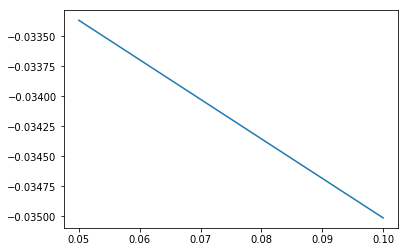

In [19]:
plt.plot(sched.lrs, sched.losses)

### Optimizer Parameters

In [30]:
# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=.1,momentum=0.99,wd=0.000001)

In [31]:
updater.optimizer.lr_scheduler=None

In [32]:
updater = mx.optimizer.get_updater(opt)

## Train Model

In [34]:
Es_train=[]
for epoch in range(0,epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 2.8861985206604004 Epoch: 0 trainloss: -0.035242498 validloss: -0.04459971
time: 2.875284433364868 Epoch: 1 trainloss: -0.03519571 validloss: -0.044599984
time: 2.9444684982299805 Epoch: 2 trainloss: -0.035210036 validloss: -0.044600334
time: 2.91548490524292 Epoch: 3 trainloss: -0.035240326 validloss: -0.04460079
time: 2.948451519012451 Epoch: 4 trainloss: -0.03523682 validloss: -0.04460133
time: 2.9097959995269775 Epoch: 5 trainloss: -0.035221487 validloss: -0.044601943
time: 2.885143280029297 Epoch: 6 trainloss: -0.03523396 validloss: -0.044602647
time: 3.013814926147461 Epoch: 7 trainloss: -0.035244685 validloss: -0.044603437
time: 2.946488618850708 Epoch: 8 trainloss: -0.035228767 validloss: -0.044604298
time: 3.0086567401885986 Epoch: 9 trainloss: -0.03513771 validloss: -0.044605266
time: 3.048368453979492 Epoch: 10 trainloss: -0.03523555 validloss: -0.044606287
time: 2.8409059047698975 Epoch: 11 trainloss: -0.03524836 validloss: -0.04460739
time: 2.8395092487335205 Epoch: 

time: 2.8441755771636963 Epoch: 101 trainloss: -0.035352696 validloss: -0.044816863
time: 2.9736204147338867 Epoch: 102 trainloss: -0.035369456 validloss: -0.044819113
time: 2.849853515625 Epoch: 103 trainloss: -0.03536984 validloss: -0.04482135
time: 2.8428947925567627 Epoch: 104 trainloss: -0.03538218 validloss: -0.044823576
time: 2.8458056449890137 Epoch: 105 trainloss: -0.035383873 validloss: -0.04482578
time: 2.8433220386505127 Epoch: 106 trainloss: -0.03538549 validloss: -0.044827964
time: 2.8448429107666016 Epoch: 107 trainloss: -0.03538002 validloss: -0.044830143
time: 2.850235939025879 Epoch: 108 trainloss: -0.035338145 validloss: -0.04483231
time: 2.842726230621338 Epoch: 109 trainloss: -0.035376314 validloss: -0.044834465
time: 2.844866991043091 Epoch: 110 trainloss: -0.035387233 validloss: -0.044836596
time: 2.8442697525024414 Epoch: 111 trainloss: -0.035392135 validloss: -0.044838708
time: 2.8420913219451904 Epoch: 112 trainloss: -0.03538212 validloss: -0.04484081
time: 2.

time: 2.863316059112549 Epoch: 201 trainloss: -0.03545399 validloss: -0.044974722
time: 2.8764166831970215 Epoch: 202 trainloss: -0.035469785 validloss: -0.044975743
time: 2.8956260681152344 Epoch: 203 trainloss: -0.035473805 validloss: -0.04497676
time: 2.8805270195007324 Epoch: 204 trainloss: -0.03547927 validloss: -0.044977766
time: 2.8785324096679688 Epoch: 205 trainloss: -0.035479628 validloss: -0.044978764
time: 2.85897159576416 Epoch: 206 trainloss: -0.035477743 validloss: -0.044979755
time: 2.8703091144561768 Epoch: 207 trainloss: -0.0354715 validloss: -0.04498074
time: 2.870919942855835 Epoch: 208 trainloss: -0.03543519 validloss: -0.044981714
time: 2.858908176422119 Epoch: 209 trainloss: -0.035405066 validloss: -0.04498268
time: 2.857144355773926 Epoch: 210 trainloss: -0.035431743 validloss: -0.04498364
time: 2.858804225921631 Epoch: 211 trainloss: -0.035464957 validloss: -0.044984594
time: 2.857579469680786 Epoch: 212 trainloss: -0.035483625 validloss: -0.044985544
time: 2.8

time: 2.859771728515625 Epoch: 301 trainloss: -0.035522707 validloss: -0.04504737
time: 2.8596394062042236 Epoch: 302 trainloss: -0.035504162 validloss: -0.04504787
time: 2.8978569507598877 Epoch: 303 trainloss: -0.035517644 validloss: -0.04504838
time: 2.8781373500823975 Epoch: 304 trainloss: -0.035522345 validloss: -0.045048878
time: 2.863086700439453 Epoch: 305 trainloss: -0.035491 validloss: -0.045049373
time: 2.8651938438415527 Epoch: 306 trainloss: -0.03550429 validloss: -0.045049872
time: 2.866264820098877 Epoch: 307 trainloss: -0.035466254 validloss: -0.04505036
time: 2.8642263412475586 Epoch: 308 trainloss: -0.035465863 validloss: -0.045050852
time: 2.8655402660369873 Epoch: 309 trainloss: -0.03551236 validloss: -0.045051336
time: 2.8684449195861816 Epoch: 310 trainloss: -0.035496414 validloss: -0.045051824
time: 2.866743803024292 Epoch: 311 trainloss: -0.03551289 validloss: -0.045052305
time: 2.864281415939331 Epoch: 312 trainloss: -0.035481136 validloss: -0.045052778
time: 2

time: 2.858048677444458 Epoch: 401 trainloss: -0.035546772 validloss: -0.04508644
time: 2.855037212371826 Epoch: 402 trainloss: -0.035544503 validloss: -0.04508674
time: 2.8563156127929688 Epoch: 403 trainloss: -0.035547428 validloss: -0.045087036
time: 2.8563437461853027 Epoch: 404 trainloss: -0.03554427 validloss: -0.045087337
time: 2.8591148853302 Epoch: 405 trainloss: -0.035546944 validloss: -0.045087628
time: 2.858712673187256 Epoch: 406 trainloss: -0.035474785 validloss: -0.045087922
time: 2.8588125705718994 Epoch: 407 trainloss: -0.035546362 validloss: -0.045088217
time: 2.8607866764068604 Epoch: 408 trainloss: -0.035508506 validloss: -0.045088507
time: 2.8572981357574463 Epoch: 409 trainloss: -0.035548598 validloss: -0.045088794
time: 2.875377893447876 Epoch: 410 trainloss: -0.035535675 validloss: -0.045089085
time: 2.8912103176116943 Epoch: 411 trainloss: -0.03554809 validloss: -0.045089375
time: 2.8760669231414795 Epoch: 412 trainloss: -0.035536487 validloss: -0.04508966
time

time: 2.8661670684814453 Epoch: 500 trainloss: -0.035556555 validloss: -0.04511076


In [24]:
Es_train[-5:]

[-0.03210952, -0.0256772, -0.044658914, -0.034622647, -0.035864435]

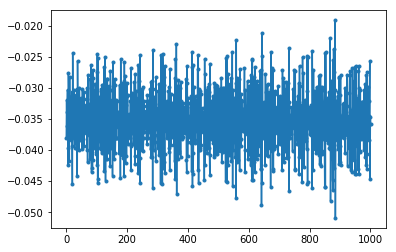

In [29]:
plt.plot(Es_train,'.-')

## Evaluate Model

In [26]:
BATCH_SIZE=1
test_iter=nn.FileIter(test_data_path,test_idx_path,batch_size=BATCH_SIZE,do_shuffle=False,mean_image=x_mean,std_image = x_std)

In [27]:
def get_sample_at(valid_iter,n):
    valid_iter.ind2=[n]
    return valid_iter.next()

In [28]:
K = valid_iter.num_data
n = random.randint(0,K)
print('index = '+ str(n))
batch = get_sample_at(valid_iter,n)


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.7, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none',  alpha=0.4, vmin=0, vmax=1)


      
plt.tight_layout()

index = 36


StopIteration: 